In [2]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

In [4]:
print(core_tabler.metadata.shape)
core_tabler.metadata.head()

(3699, 47)


,metasub_name,core_project,project,city,city_code,latitude,longitude,surface_material,control_type,elevation,...,plate_number,plate_pos,sample_type,sl_name,control_type_fine,control_type_coarse,surface_ontology_fine,surface_ontology_coarse,coastal,city_elevation
uuid,,,,,,,,,,,,,,,,,,,,,
haib17CEM4890_H75CGCCXY_SL263637,CSD16-AKL-002,core,CSD16,auckland,AKL,-36.862361,174.809565,glass,NaN,NaN,...,NaN,NaN,environmental_microbiome,SL263637,NaN,NaN,metal,impermeable,"(coastal, coastal)",coastal
haib17CEM4890_H75CGCCXY_SL263649,CSD16-AKL-003,core,CSD16,auckland,AKL,-36.862437,174.809512,metal,NaN,NaN,...,NaN,NaN,environmental_microbiome,SL263649,NaN,NaN,metal,impermeable,"(coastal, coastal)",coastal
haib17CEM4890_H75CGCCXY_SL263661,CSD16-AKL-006,core,CSD16,auckland,AKL,-36.862345,174.809494,metal,NaN,NaN,...,NaN,NaN,environmental_microbiome,SL263661,NaN,NaN,metal,impermeable,"(coastal, coastal)",coastal
haib17CEM4890_H75CGCCXY_SL263673,CSD16-AKL-007,core,CSD16,auckland,AKL,-36.866272,174.820725,wood,NaN,NaN,...,NaN,NaN,environmental_microbiome,SL263673,NaN,NaN,biological,permeable,"(coastal, coastal)",coastal
haib17CEM4890_H75CGCCXY_SL263685,CSD16-AKL-008,core,CSD16,auckland,AKL,-36.866310,174.820751,glass,NaN,NaN,...,NaN,NaN,environmental_microbiome,SL263685,NaN,NaN,metal,impermeable,"(coastal, coastal)",coastal


In [5]:
from numpy.random import choice

taxa = core_tabler.taxonomy().sample(1000).fillna(0)


def rarefy_row(row, n=1000):
    pvals = row.values
    pvals /= sum(pvals)
    vals = choice(row.index, p=pvals, size=(n,))
    tbl = {}
    for val in vals:
        tbl[val] = 1 + tbl.get(val, 0)
    return pd.Series(tbl)

rarefied = {}
for n in [100, 1000, 10 * 1000, 100 * 1000, 1000 * 1000, 5 * 1000 * 1000]:
    rarefied[n] = (taxa.apply(rarefy_row, n=n, axis=1).fillna(0) > 0).sum(axis=1)
rarefied = pd.DataFrame.from_dict(rarefied, orient='columns')
rarefied['sample'] = [str(el) for el in rarefied.index]
rarefied = rarefied.melt(id_vars='sample')
rarefied['variable'] = rarefied['variable'].map(int)
rarefied.head()

,sample,variable,value
0,haib17CEM5106_HCY5HCCXY_SL271147,100,44
1,haib17CEM5241_HMGMHCCXY_SL343444,100,80
2,haib18CEM5526_HMGTJCCXY_SL342620,100,68
3,haib18CEM5453_HT5YVCCXY_SL357432,100,59
4,haib17CEM5106_HCY5HCCXY_SL270946,100,49


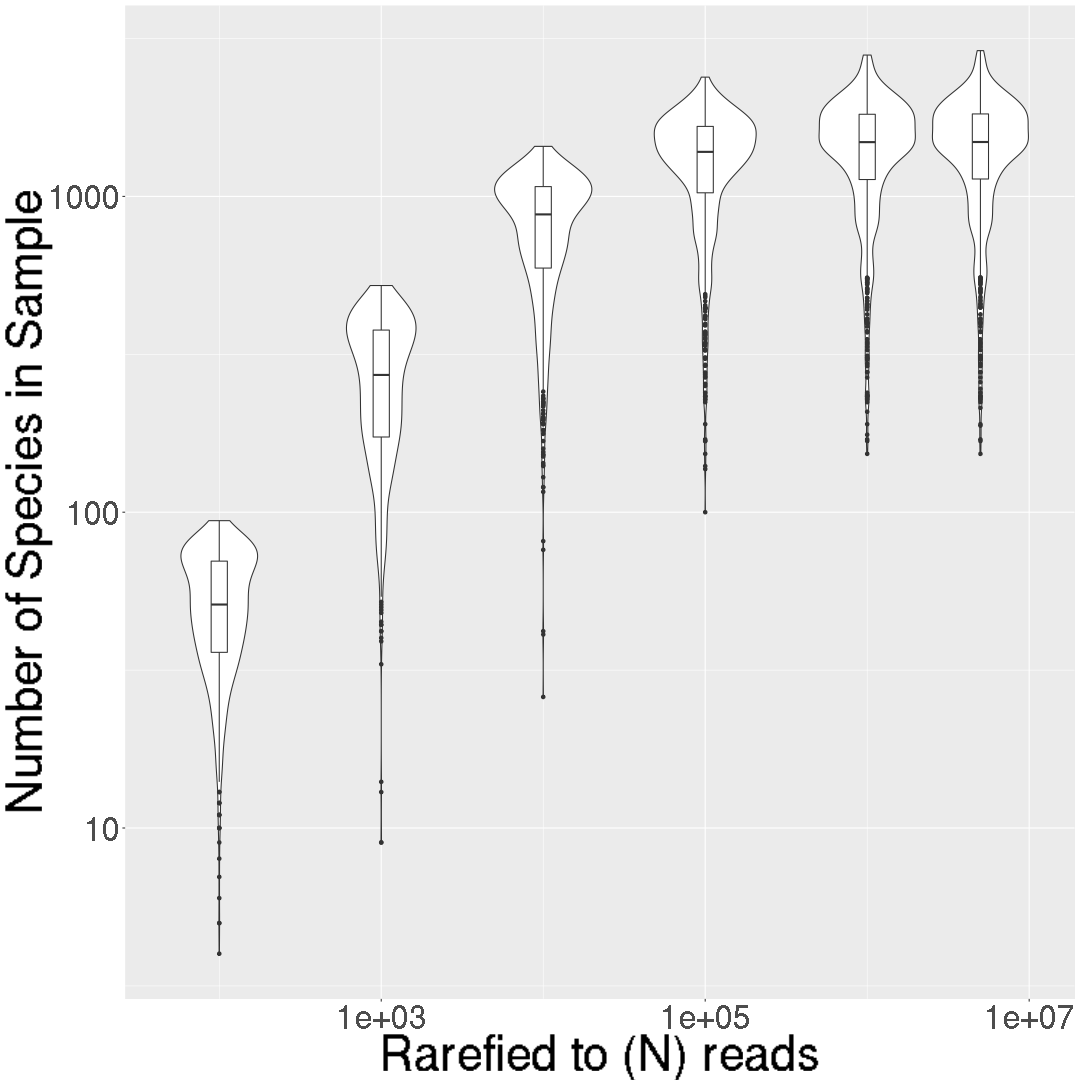

In [19]:
%%R -i rarefied -w 1080 -h 1080


ggplot(rarefied, aes(x=variable, y=value)) +
    geom_violin(aes(group=variable)) +
    geom_boxplot(aes(group=variable), width=0.1) +
    scale_y_log10() +
    scale_x_log10() +
    xlab('Rarefied to (N) reads') +
    ylab('Number of Species in Sample') +
    theme(
        text=element_text(size=50)
    )

In [7]:
long_taxa = pd.read_csv('~/Dropbox/resources_and_shared/metasub_data_packets/metasub_data_packet_v1_0/taxonomy/100_samples.taxa_longform.csv')
long_taxa.columns = ['uuid', 'taxa', 'taxid', 'rank', 'mpa', 'cov', 'dup', 'kmers', 'percent', 'reads', 'tax_reads']
long_taxa.head()

,uuid,taxa,taxid,rank,mpa,cov,dup,kmers,percent,reads,tax_reads
0,haib17CEM4890_H2NYMCCXY_SL254780,root,1,no rank,x__root,0.002150,9.87,29458154,30.25,6030794,1781
1,haib17CEM4890_H2NYMCCXY_SL254780,unclassified,0,no rank,x__unclassified,NaN,6.36,679702300,69.75,13903271,13903271
2,haib17CEM4890_H3KHWCCXY_SL263298,root,1,no rank,x__root,0.000435,4.02,5963616,16.17,523778,1418
3,haib17CEM4890_H3KHWCCXY_SL263298,unclassified,0,no rank,x__unclassified,NaN,2.24,303075430,83.83,2715934,2715934
4,haib17CEM4890_H3KHWCCXY_SL263300,root,1,no rank,x__root,0.000956,5.12,13105905,35.18,992535,717


In [8]:

KMER_VALS = [2 ** i for i in range(6, 21)]

def count_taxa(tbl):
    out = {}
    for k in KMER_VALS:
        tbl = tbl.query('kmers >= @k')
        out[k] = tbl['taxa'].nunique()
    return pd.Series(out)

taxa_counts = long_taxa.groupby('uuid').apply(count_taxa)
taxa_counts.head()

,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072,262144,524288,1048576
uuid,,,,,,,,,,,,,,,
haib17CEM4890_H2NYMCCXY_SL254780,8144,6534,5167,3888,2649,1619,1050,620,383,238,177,138,104,72,44
haib17CEM4890_H3KHWCCXY_SL263298,7296,5656,4006,2631,1571,998,655,412,264,140,74,58,29,17,9
haib17CEM4890_H3KHWCCXY_SL263300,6801,5177,3665,2426,1632,1150,773,515,335,216,144,78,50,29,21
haib17CEM4890_H3KHWCCXY_SL263325,6817,5079,3700,2614,1813,1212,864,593,426,266,160,90,65,36,26
haib17CEM4890_H75CGCCXY_SL263640,6536,4865,3313,2235,1489,1100,821,573,367,221,133,102,83,58,44


In [9]:
taxa_counts['uuid'] = taxa_counts.index
counts = taxa_counts.melt(id_vars='uuid')
counts['uuid'] = counts['uuid'].map(str)
counts['variable'] = counts['variable'].map(int)

counts.head()

,uuid,variable,value
0,haib17CEM4890_H2NYMCCXY_SL254780,64,8144
1,haib17CEM4890_H3KHWCCXY_SL263298,64,7296
2,haib17CEM4890_H3KHWCCXY_SL263300,64,6801
3,haib17CEM4890_H3KHWCCXY_SL263325,64,6817
4,haib17CEM4890_H75CGCCXY_SL263640,64,6536


In [10]:
long_taxa['kmers'].min()

64

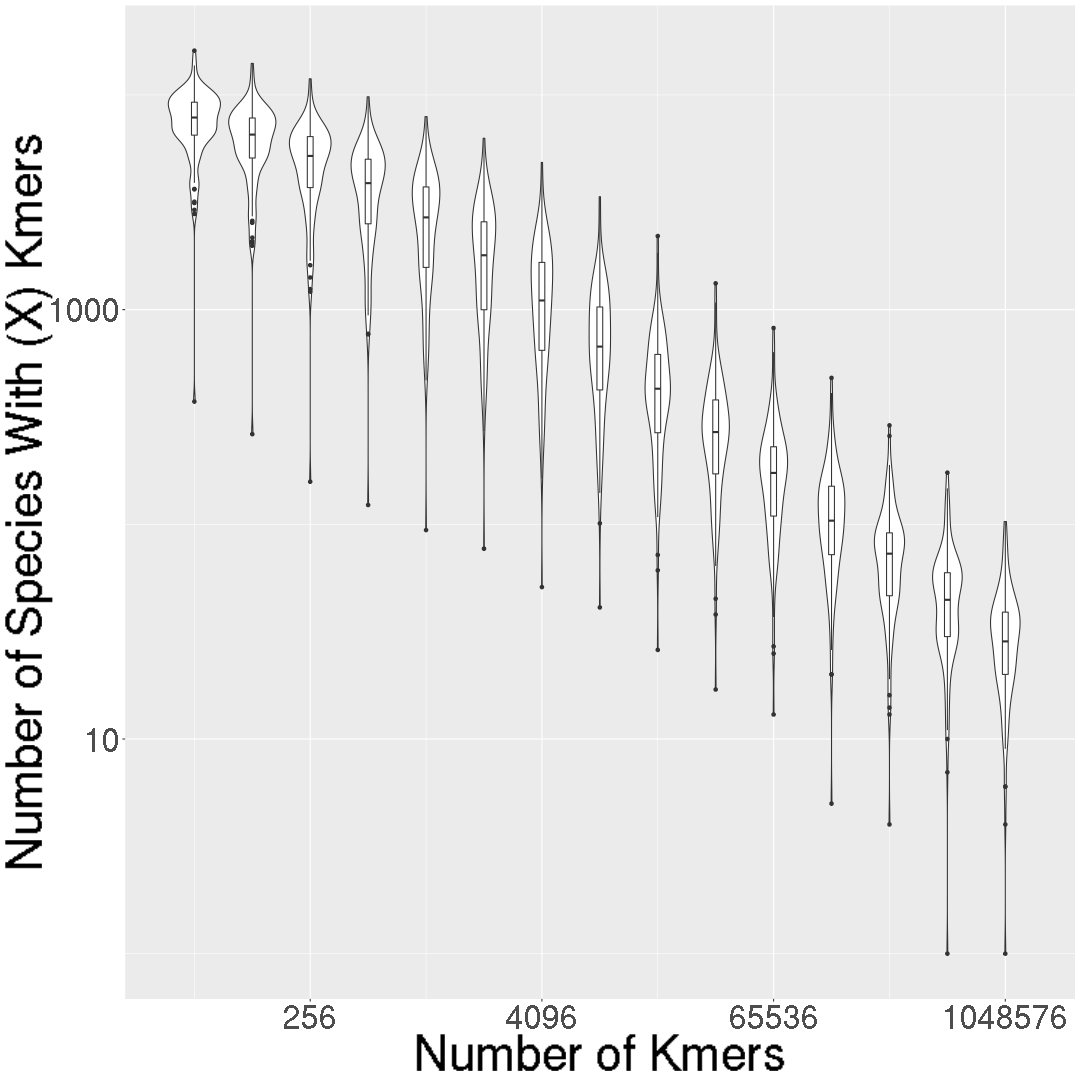

In [20]:
%%R -i counts -w 1080 -h 1080


ggplot(counts, aes(x=variable, y=value)) +
    geom_violin(aes(group=variable)) +
    geom_boxplot(aes(group=variable), width=0.1) +
    scale_y_log10() +
    scale_x_continuous(trans='log2',) +
    xlab('Number of Kmers') +
    ylab('Number of Species With (X) Kmers') +
    theme(
        text=element_text(size=50)
    )

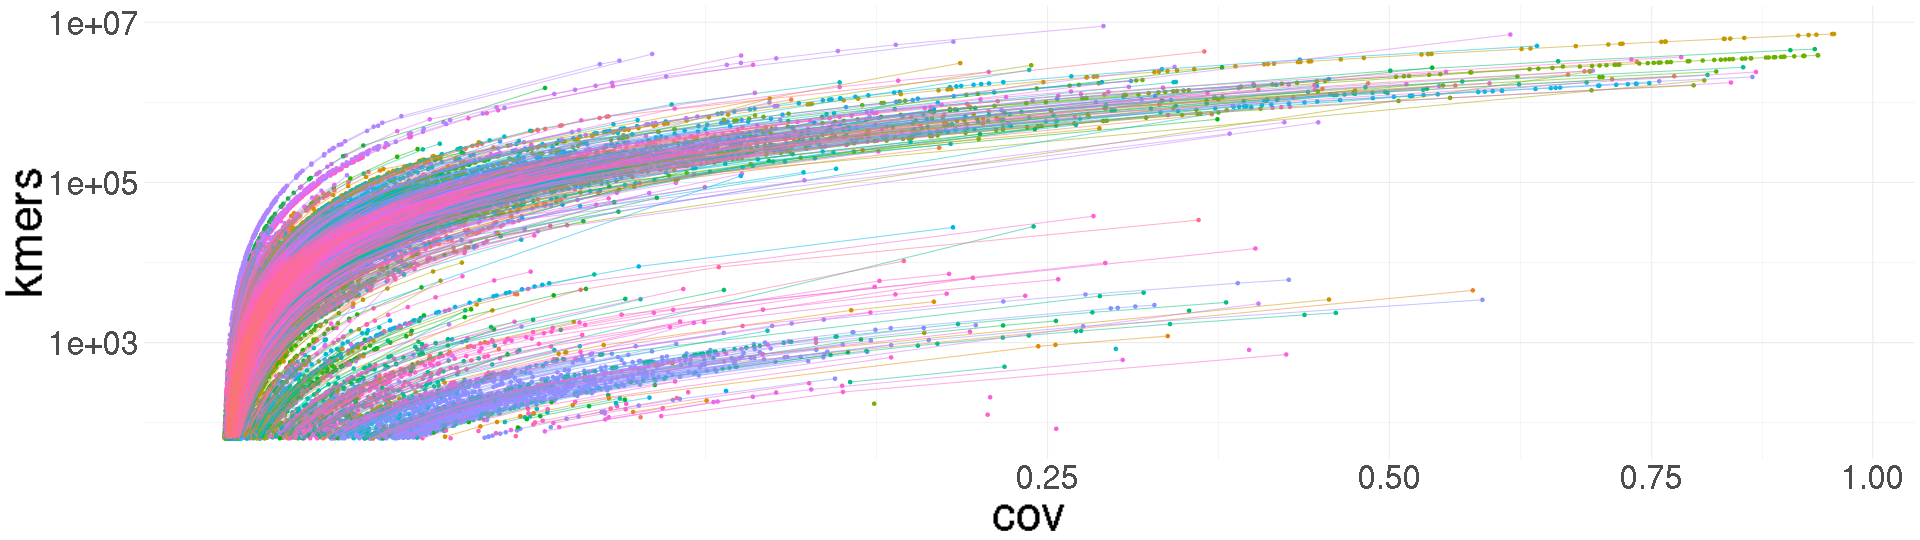

In [12]:
%%R -i long_taxa -w 1920 -h 540

ggplot(long_taxa[long_taxa$rank == 'species',], aes(x=kmers, y=cov, color=taxa)) +
    geom_point() +
    geom_line(alpha=0.5) +
    scale_x_log10()+
    scale_y_sqrt() +
    coord_flip() +
    theme_minimal() +
    theme(
        text = element_text(size=50),
        legend.position='none',
    )

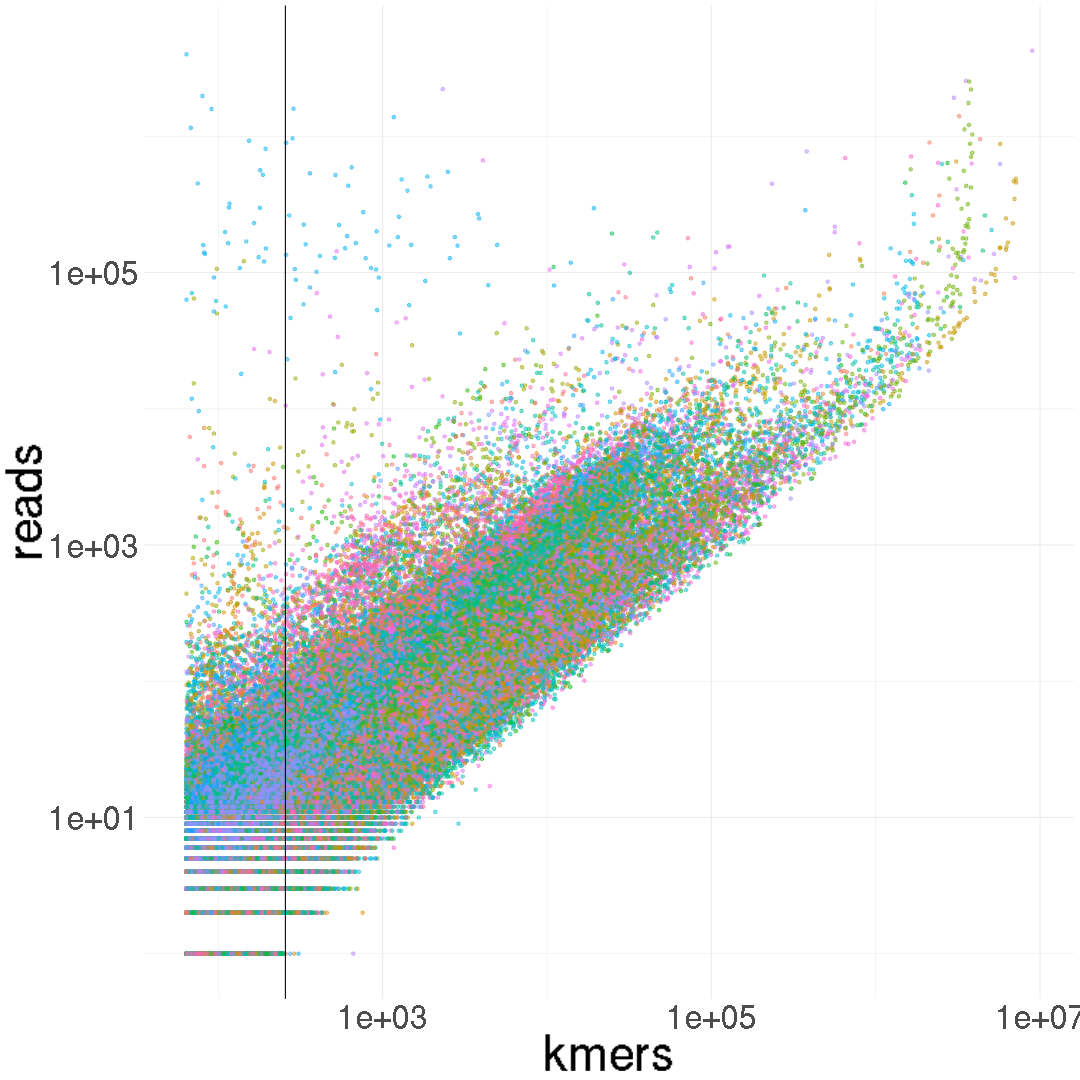

In [13]:
%%R -i long_taxa -w 1080 -h 1080

ggplot(long_taxa[long_taxa$rank == 'species',], aes(x=kmers, y=reads, color=taxa)) +
    geom_point(alpha=0.5) +
    scale_x_log10()+
    scale_y_log10() +
    theme_minimal() +
    #scale_color_brewer(palette='Spectral') +
    geom_vline(xintercept=256) +
    theme(
        text = element_text(size=50),
        legend.position='none',
    )

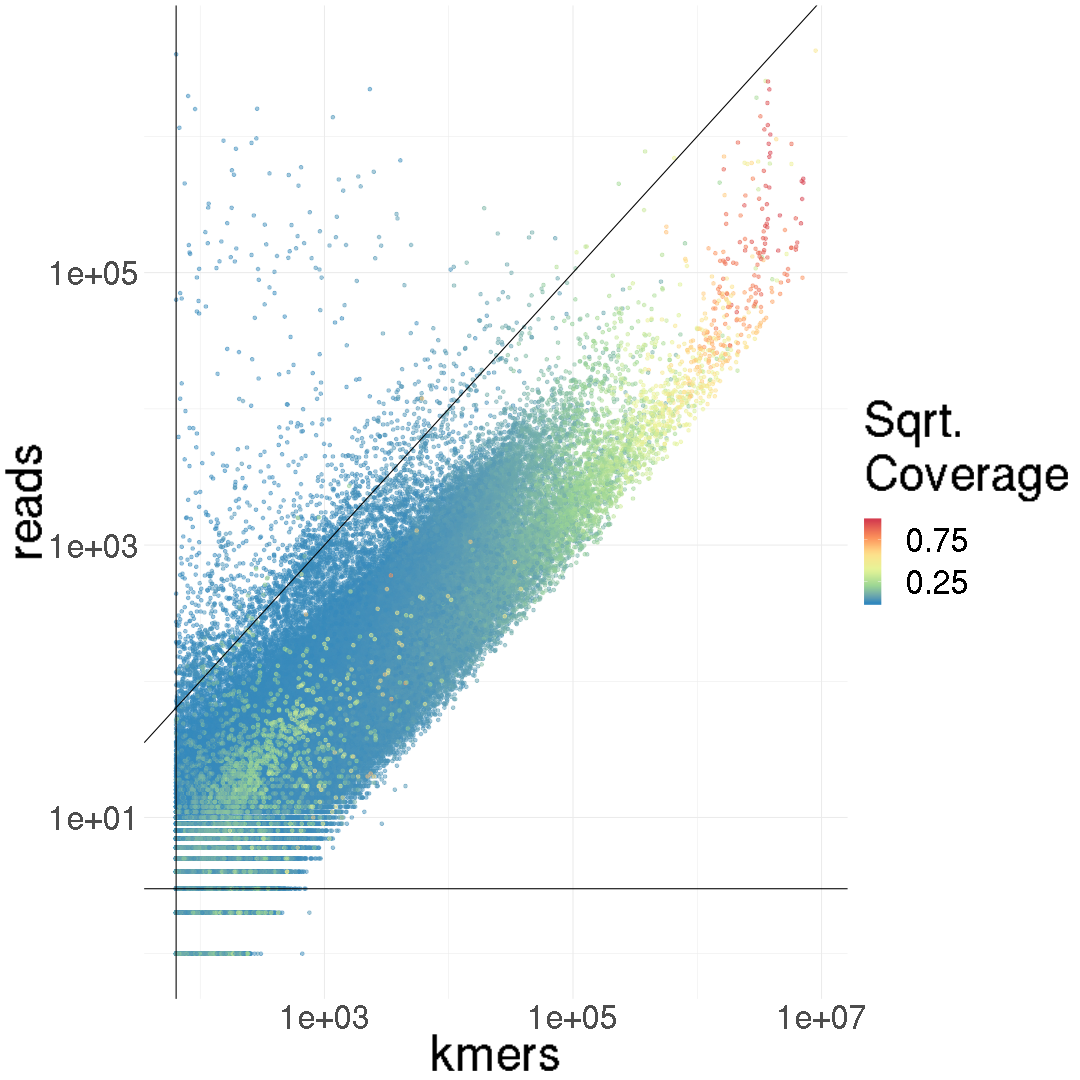

In [22]:
%%R -i long_taxa -w 1080 -h 1080

long_taxa$rcov = sqrt(long_taxa$cov)
ggplot(long_taxa[long_taxa$rank == 'species',], aes(x=kmers, y=reads, color=rcov)) +
    geom_point(alpha=0.5) +
    scale_x_log10()+
    scale_y_log10() +
    theme_minimal() +
    scale_color_distiller(palette='Spectral', breaks=c(0.25, 0.75)) +
    geom_vline(xintercept=64) +
    geom_hline(yintercept=3) +
    geom_abline(a=0, b=(100/250)) +
    labs(color='Sqrt.\nCoverage') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

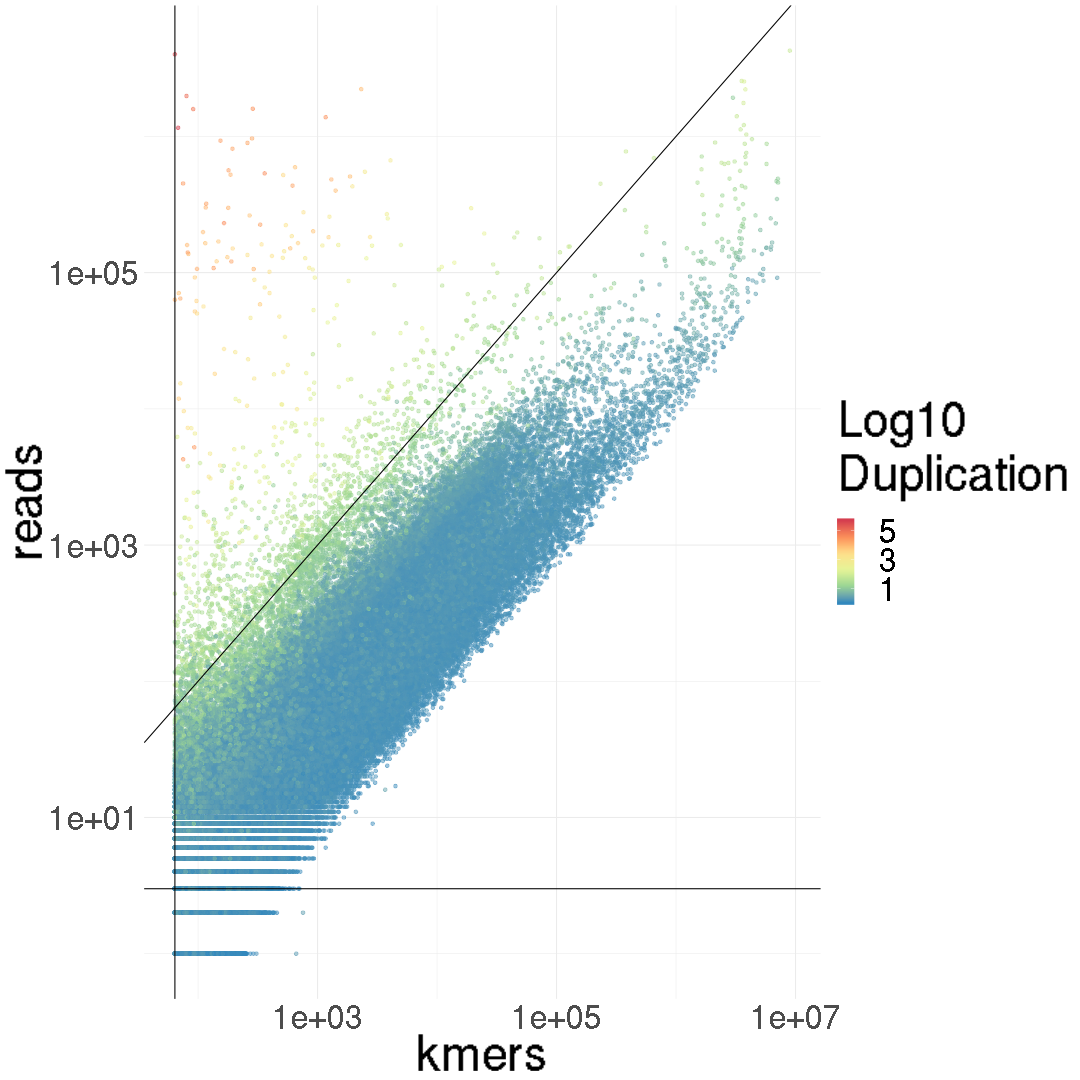

In [23]:
%%R -i long_taxa -w 1080 -h 1080

long_taxa$ldup = log10(long_taxa$dup)
ggplot(long_taxa[long_taxa$rank == 'species',], aes(x=kmers, y=reads, color=ldup)) +
    geom_point(alpha=0.5) +
    scale_x_log10()+
    scale_y_log10() +
    theme_minimal() +
    scale_color_distiller(palette='Spectral', breaks=c(1, 3, 5)) +
    geom_vline(xintercept=64) +
    geom_hline(yintercept=3) +
    geom_abline(a=0, b=(100/256)) +
    labs(color='Log10\nDuplication') +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

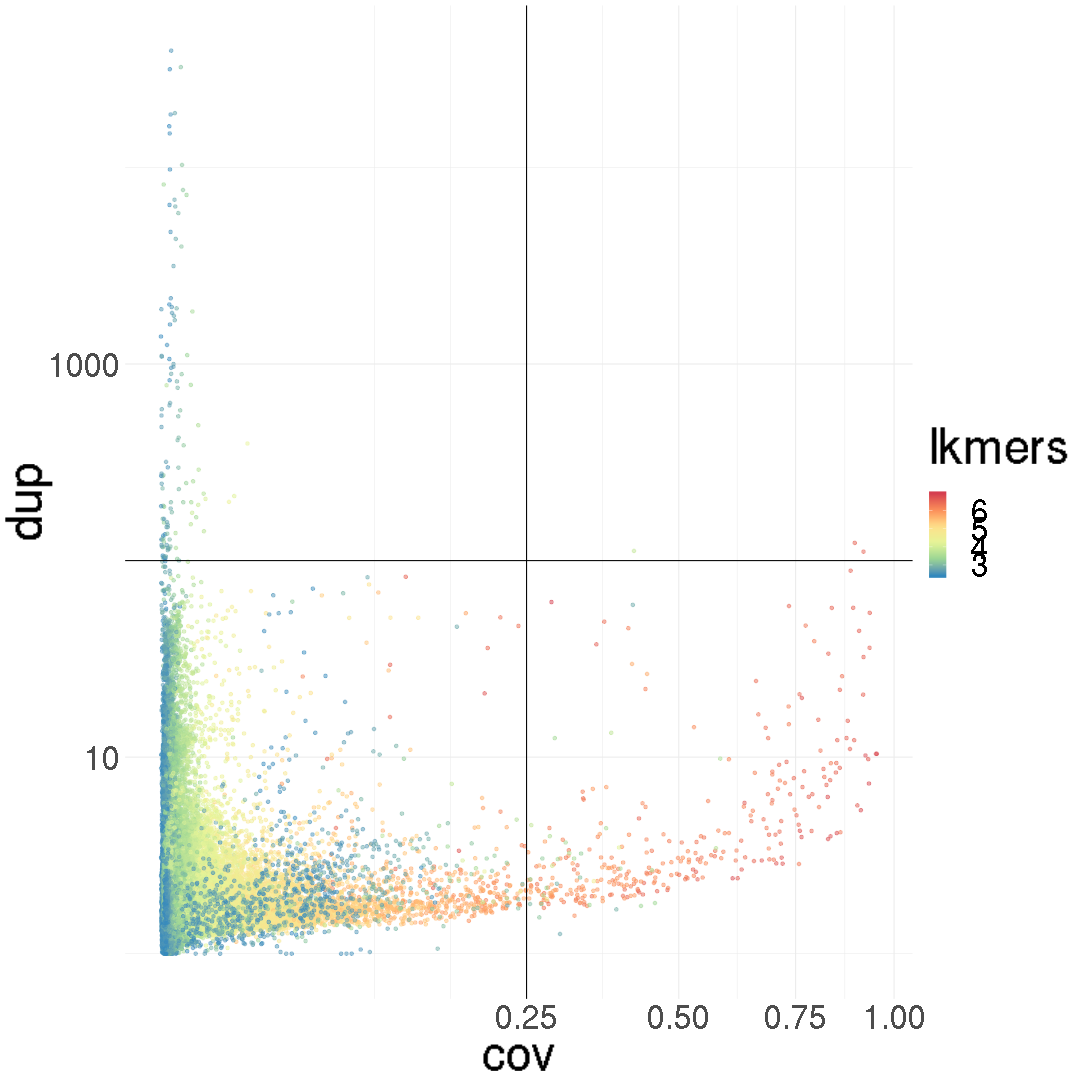

In [16]:
%%R -i long_taxa -w 1080 -h 1080

long_taxa$lkmers = log10(long_taxa$kmers)
s = long_taxa[long_taxa$rank == 'species',]
s = s[s$kmers >= 256,]
ggplot(s, aes(x=cov, y=dup, color=lkmers)) +
    geom_point(alpha=0.5) +
    scale_x_sqrt()+
    scale_y_log10() +
    theme_minimal() +
    scale_color_distiller(palette='Spectral') +
    geom_hline(yintercept=100) +
    geom_vline(xintercept=0.25) +
    theme(
        text = element_text(size=50),
        legend.position='right',
    )

In [26]:
scores = pd.read_csv(core_tabler.packet_dir + '/other/sub_core_taxa_diagnostic_indices.csv', names=['sample', 'species', 'MSE', 'CE'])

mean_scores = scores.groupby('species').mean()
mean_scores['species'] = mean_scores.index

scores.head()

,sample,species,MSE,CE
0,haib18CEM5453_HMGW3CCXY_SL342547,Pseudomonas_balearica,NaN,NaN
1,haib18CEM5453_HNHKFCCXY_SL345587,Pseudomonas_balearica,NaN,NaN
2,haib18CEM5453_HT5YVCCXY_SL357477,Pseudomonas_balearica,0.855339,0.265425
3,haib17CEM4890_H75CGCCXY_SL263643,Pseudomonas_balearica,0.864057,0.255636
4,haib18CEM5453_HMC2KCCXY_SL336655,Pseudomonas_balearica,0.866122,0.158880


In [27]:
len(set(mean_scores.query('CE < 0.1').index) | set(mean_scores.query('MSE < 0.75').index))

69

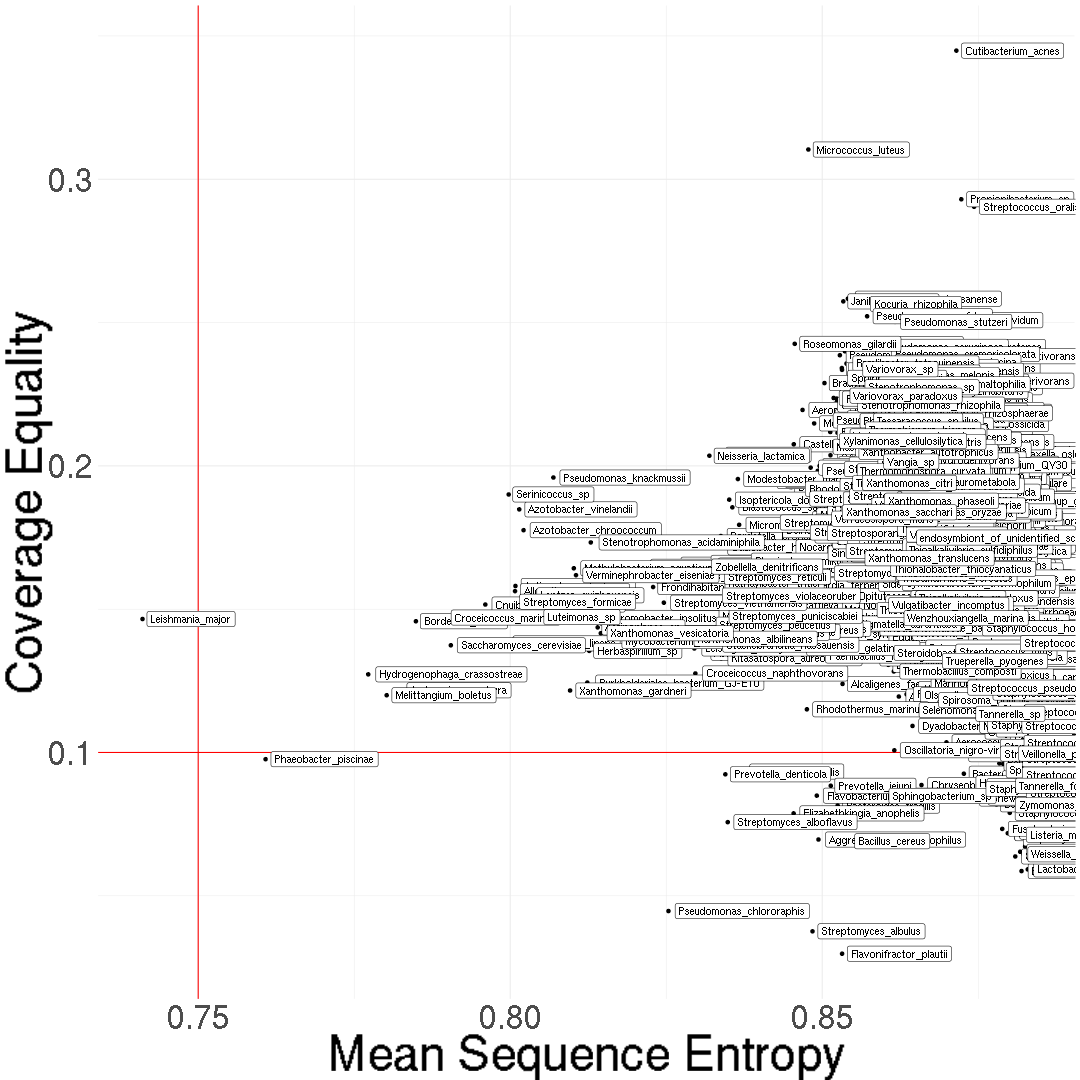

In [28]:
%%R -i mean_scores -w 1080 -h 1080

ggplot(mean_scores, aes(x=MSE, y=CE, label=species)) +
    geom_hline(yintercept=0.1, color='red') +
    geom_vline(xintercept=0.75, color='red') +
    geom_point() +
    geom_label(hjust=-0.05) + 
    theme_minimal() +
    xlab('Mean Sequence Entropy') +
    ylab('Coverage Equality') +
    theme(
        text = element_text(size=50),
    )